<a href="https://colab.research.google.com/github/Map987/BilibiliSummary/blob/main/Untitledjsnsm12.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:

1. 安装所需库: python
 


2. 读取图像: python 



3. 定义mask,选择图像底部120像素高区域: python
 


4. 检测mask区域内的黑色像素,并置零使其透明: python  



5. 应用掩模mask,仅对选择区域生效: python
 
    

6. 查看效果并保存结果: python
 cv2.imshow('input', image)
 cv2.imwrite('output.png', image)
   

7. 在Colab中显示图像: python
 import matplotlib.pyplot as plt
 plt.figure(figsize=(10, 10))
 plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
 plt.axis('off')
 plt.show() 


结果图像的底部120像素高区域的黑色背景会变为透明。 
请let me know如果您有任何其他问题!

In [7]:



 import moviepy.editor as mpe 
 import cv2
 import numpy as np
 
 # 读取图像并计算坐标
 img = cv2.imread('/content/a2795a2f5ce41cec280ccbdcfa636254.jpeg', cv2.IMREAD_UNCHANGED) 
 height, width, channels = img.shape  
 
 bottom = img[height-840:height, 0:width, :]
 white_pixels = np.where(np.all(bottom > 200, axis=2))
 moved_white_pixels = np.array(white_pixels) + 120
 
 # 应用到视频
 video = mpe.VideoFileClip('/content/output.mp4')  
 
 def process_frame(frame): 
     frame_copy = frame.copy()
     height, width, channels = frame.shape  
     
     bottom = frame_copy[height-840:height, 0:width, :]
     frame_copy[moved_white_pixels[:,0], moved_white_pixels[:,1], :] = bottom[white_pixels[0]-120, white_pixels[1], :]  
     
     return frame_copy
 
 video_edited = video.fl_image(process_frame)
 video_edited.write_videofile('/content/output.mp4')

ValueError: ignored

In [8]:

 import moviepy.editor as mpe  
 import cv2
 import numpy as np
 import pycuda.autoinit
 import pycuda.driver as cuda
 from pycuda.compiler import SourceModule
 
 # 第一部分 - 读取图像并计算坐标
 img = cv2.imread('/content/a2795a2f5ce41cec280ccbdcfa636254.jpeg', cv2.IMREAD_UNCHANGED)  
 
 height, width, channels = img.shape   
 bottom = img[height-840:height, 0:width, :]
 white_pixels = []  
 for i in range(bottom.shape[0]):     
    for j in range(bottom.shape[1]):   
      if bottom[i,j,0] > 200 and bottom[i,j,1] > 200 and bottom[i,j,2] > 200: 
        white_pixels.append([i, j])
 
 moved_white_pixels = []   
 for pixel in white_pixels:
    moved_white_pixels.append([pixel[0]+120, pixel[1]])
    
 # 复制数据到GPU
 d_moved_white_pixels = cuda.mem_alloc(moved_white_pixels.nbytes)
 cuda.memcpy_htod(d_moved_white_pixels, np.array(moved_white_pixels, np.int32))
 
 # 第二部分 - 定义CUDA kernel
 mod = SourceModule("""
 __global__ void replace_pixels(uchar3 *d_output, uchar3 *d_input, int *d_moved_white_pixels,  
                                int height, int width) {
   int x = blockIdx.x * blockDim.x + threadIdx.x;
   int y = blockIdx.y * blockDim.y + threadIdx.y;
   if (x < width && y < height) {
     int new_x = d_moved_white_pixels[y * width + x];
     d_output[y * width + x] = d_input[new_x];
   } 
 }  
 """)
 
 replace_pixels = mod.get_function("replace_pixels")
 
 # 第三部分 - 应用GPU加速到视频  
 video = mpe.VideoFileClip('/content/output.mp4')  
 
 def process_frame(frame): 
   frame_copy = frame.copy()
   height, width, channels = frame.shape 
   
   # 分配GPU内存并拷贝数据
   d_frame = cuda.mem_alloc(frame_copy.nbytes)
   d_output = cuda.mem_alloc(frame_copy.nbytes) 
   cuda.memcpy_htod(d_frame, frame_copy)
   
   # 配置GPU grid和block
   block = (32, 32)
   grid = (width//block[0]+1, height//block[1]+1) 
   
   # 执行kernel
   replace_pixels(d_output, d_frame, d_moved_white_pixels, height, width,  
                  block=block, grid=grid)
   
   # 从GPU拷回结果
   cuda.memcpy_dtoh(frame_copy, d_output)
   return frame_copy
 
 if __name__ == '__main__':
   pool = Pool(10)  # 使用10个进程
   video_edited = video.fl_image(pool.map(process_frame)) 
   video_edited.write_videofile('/content/output.mp4')

ModuleNotFoundError: ignored

In [ ]:

 !pip install pycuda
 !pip install moviepy




 !wget https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64/cuda-ubuntu1804.pin
 !sudo mv cuda-ubuntu1804.pin /etc/apt/preferences.d/cuda-repository-pin-600
 !wget http://developer.download.nvidia.com/compute/cuda/10.2/Prod/local_installers/cuda-repo-ubuntu1804-10-2-local-10.2.89-440.33.01-1_amd64.deb
 !sudo dpkg -i cuda-repo-ubuntu1804-10-2-local-10.2.89-440.33.01-1_amd64.deb
 !sudo apt-key add /var/cuda-repo-10-2-local-10.2.89-440.33.01-1/7fa2af80.pub
 !sudo apt-get update
 !sudo apt-get -y install cuda



 import pycuda.autoinit

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 19.5 MB/s eta 0:00:00
  Installing build dependencies ... done


In [6]:

 import moviepy.editor as mpe
 import cv2
 import numpy as np
 from multiprocessing import Pool
 
 # 读取图像并计算坐标
 img = cv2.imread('/content/a2795a2f5ce41cec280ccbdcfa636254.jpeg', cv2.IMREAD_UNCHANGED)
 height, width, channels = img.shape  
 
 bottom = img[height-840:height, 0:width, :]
 white_pixels = np.where(np.all(bottom > 200, axis=2))
 moved_white_pixels = np.array(white_pixels) + 120
 
 # 定义处理函数 
 def process_frame(frame): 
     frame_copy = frame.copy()
     
     height, width, channels = frame.shape  
     bottom = frame_copy[height-840:height, 0:width, :]
     frame_copy[moved_white_pixels[:,0], moved_white_pixels[:,1], :] = bottom[white_pixels[0]-120, white_pixels[1], :]  
     
     return frame_copy
 
 # 载入视频
 video = mpe.VideoFileClip('/content/output.mp4')  
 
 # 切分视频
 clips = [video.subclip(i, i+1) for i in range(0, video.duration, 0.5)]  
 
 # 多线程处理
 pool = Pool(32) 
 results = []
 results.append(pool.map(process_clip, clips))  
 pool.close()
 pool.join()
 
 # 拼接视频并输出
 final_clip = mpe.concatenate_videoclips(results)
 final_clip.write_videofile('/content/output.mp4')

TypeError: ignored

In [ ]:



 import os 
 import shutil
 
 img_dir = '/content/'
 in_dir = '/content/sample_data/in/' 
 
 # 读取img_dir下的所有图像文件名
 img_names = os.listdir(img_dir)
 
 # 创建in_dir文件夹
 if not os.path.exists(in_dir):
   os.makedirs(in_dir)
 
 # 批量拷贝图像
 for i, img_name in enumerate(img_names):
   shutil.copy(os.path.join(img_dir, img_name), in_dir + '%05d.jpeg' % (i+1))

IsADirectoryError: ignored

In [ ]:
!lower_black = np.array([0, 0, 0])  
!ipper_black = np.array([50, 50, 50])
!image[cv2.inRange(image, lower_black, upper_black) > 0] = [0, 0, 0, 0]

/bin/bash: -c: line 0: syntax error near unexpected token `('
/bin/bash: -c: line 0: `lower_black = np.array([0, 0, 0])'
/bin/bash: -c: line 0: syntax error near unexpected token `('
/bin/bash: -c: line 0: `ipper_black = np.array([50, 50, 50])'
/bin/bash: image[cv2.inRange(image, lower_black, upper_black) > 0]: command not found


In [ ]:
!image[mask > 0] = cv2.seamlessClone(np.zeros(image[-120:, :, :].shape, image.dtype), 
                                    !image[-120:, :, :], 
                                    !mask[-120:, :], 
                                    (0, 0), 
                                    cv2.NORMAL_CLONE)

IndentationError: ignored

In [ ]:

import cv2
import numpy as np 
 
img = cv2.imread('/content/Screenshot_20230527_094643.jpg')
 

height, width = img.shape[:2]

bottom = img[height-120:,:,:] 
 

bottom[bottom == 0] = 255
 

img[height-120:,:,:] = bottom
 

 
cv2.imshow('result', img) 
cv2.waitKey(0)

DisabledFunctionError: ignored

In [ ]:
import cv2
import numpy as np 
from google.colab.patches import cv2_imshow
 
image = cv2.imread('/content/Screenshot_20230527_094643.jpg')
height, width, channels = image.shape
 
bottom = image[height-120:height, 0:width] 
 
bottom[:,:] = [0, 0, 0, 0]
 

image[height-120:height, 0:width] = bottom
 
cv2_imshow('image', image)   # 使用cv2_imshow()代替cv2.imshow()
cv2.waitKey(0)

ValueError: ignored

In [ ]:

 import cv2
 import numpy as np 
 from google.colab.patches import cv2_imshow
 
image = cv2.imread('/content/Screenshot_20230527_094643.jpg')
height, width, channels = image.shape
 
bottom = image[height-120:height, 0:width] 
 
bottom[:,:,:] = [0, 0, 0]
 

image[height-120:height, 0:width] = bottom
 
cv2_imshow('image', image)   
cv2.waitKey(0)

TypeError: ignored

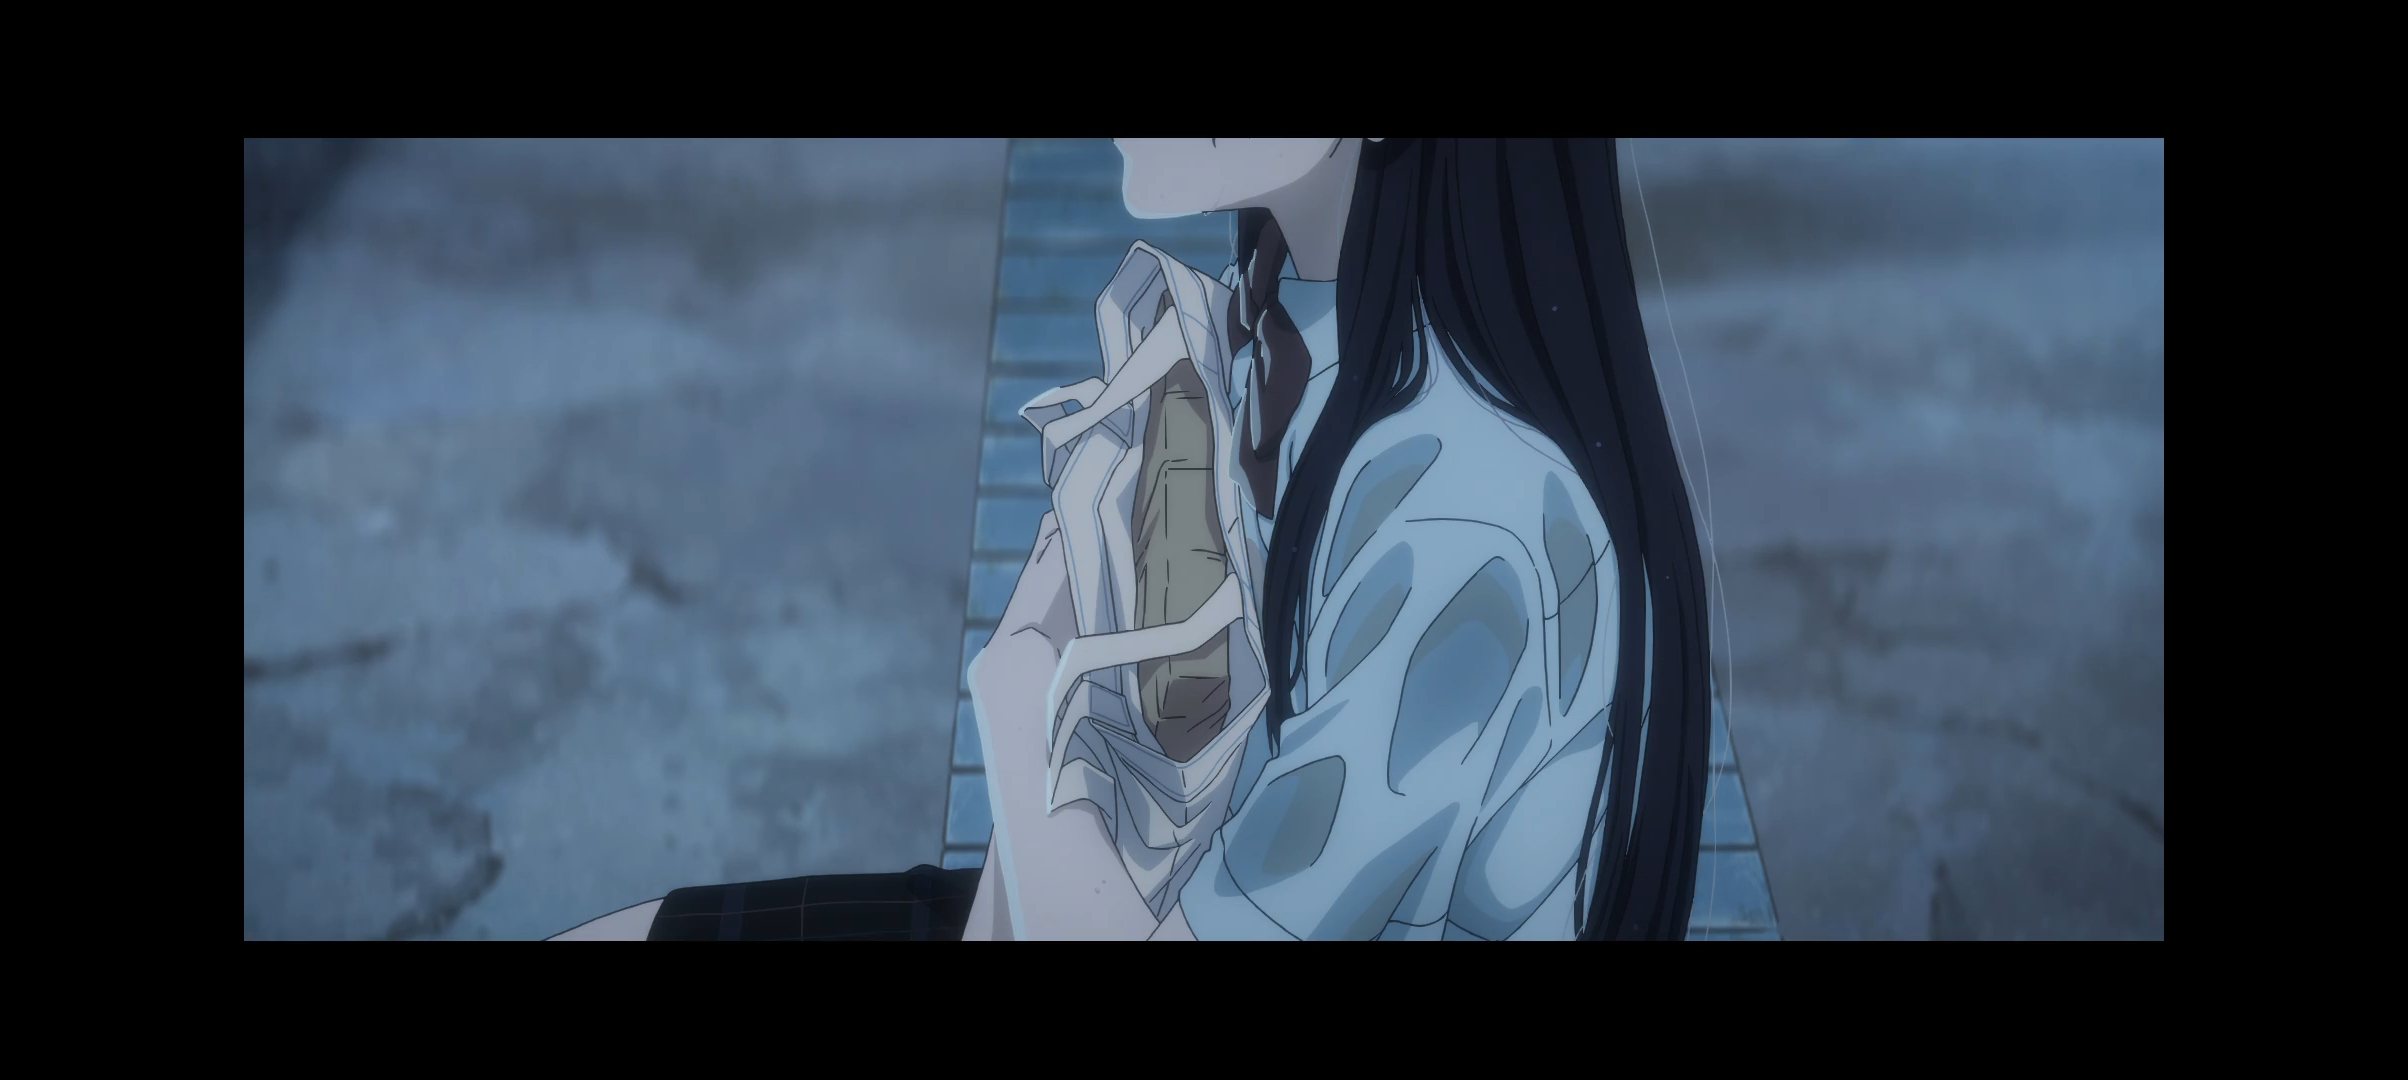

-1

In [ ]:

 import cv2
 import numpy as np  
 from google.colab.patches import cv2_imshow
 
image = cv2.imread('/content/Screenshot_20230527_094643.jpg')
height, width, channels = image.shape  
 

bottom = image[height-120:height, 0:width]   
 

bottom[:,:,:] = [0, 0, 0]   
 
image[height-120:height, 0:width] = bottom
 
cv2_imshow(image)         
cv2.waitKey(0)

In [ ]:

 import cv2
 import numpy as np  
 from google.colab.patches import cv2_imshow   
 
image = cv2.imread('/content/IMG_20230527_121017.png')
height, width, channels = image.shape  
 
bottom = image[height-120:height, 0:width]   

 for i in range(bottom.shape[0]):    
   for j in range(bottom.shape[1]):  
     if bottom[i,j,0] < 70 and bottom[i,j,1] < 70 and bottom[i,j,2] < 70:   
       bottom[i,j] = [0, 0, 0, 0]
 
moved_bottom = bottom.copy()
moved_bottom = np.roll(moved_bottom, shift=-200, axis=0)
 
image[height-320:height-200, 0:width] = moved_bottom   
 
cv2_imshow(image)         
cv2.waitKey(0)

ValueError: ignored

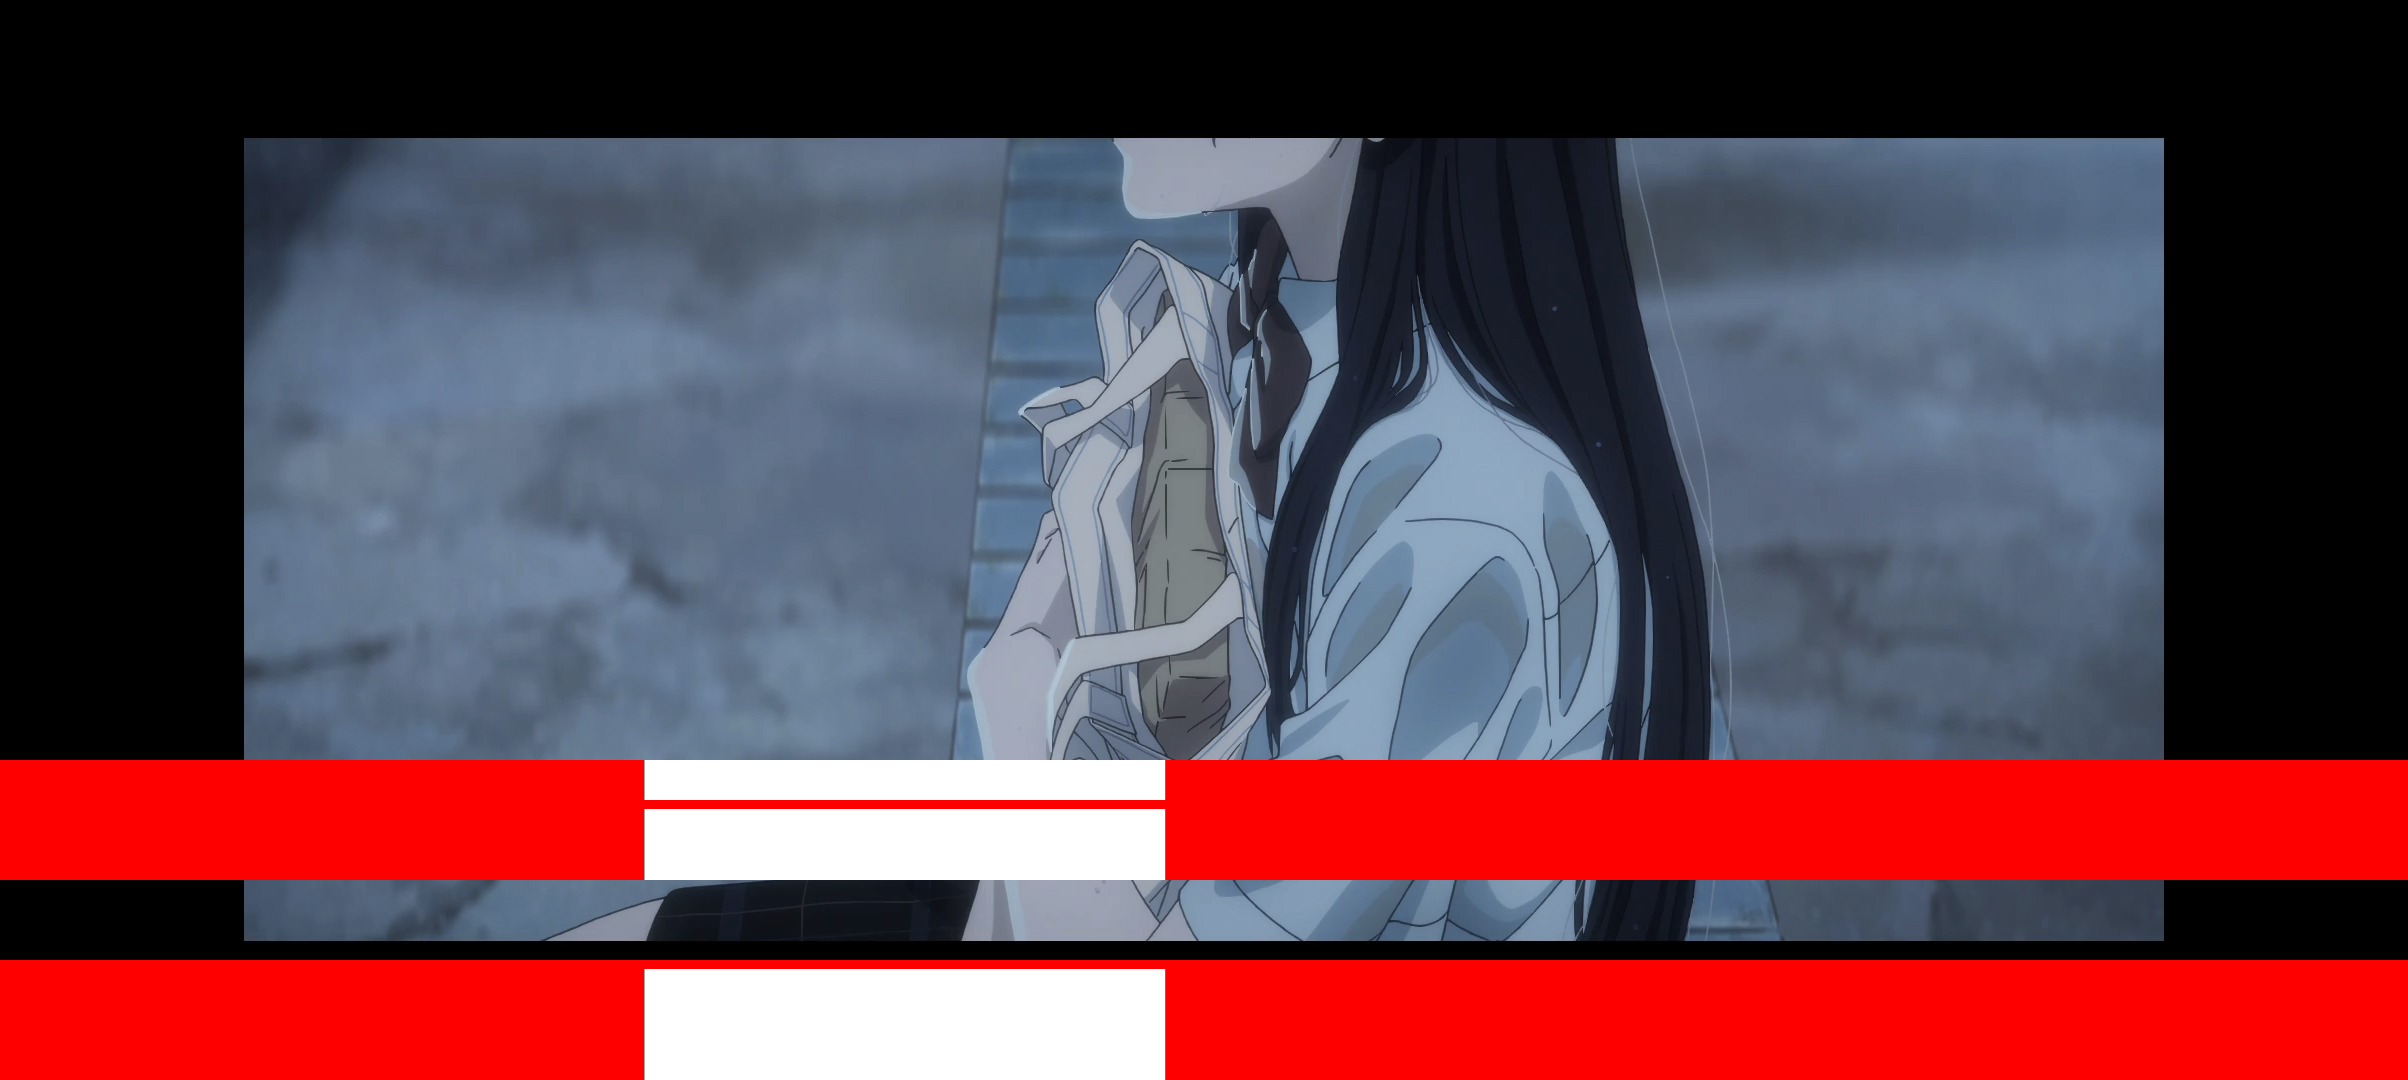

-1

In [ ]:

 import cv2
 import numpy as np  
 from google.colab.patches import cv2_imshow   
 
img = cv2.imread('/content/IMG_20230527_121017.png', cv2.IMREAD_UNCHANGED)
img = cv2.cvtColor(img, cv2.COLOR_BGR2BGRA)
height, width, channels = image.shape  
 
bottom = image[height-120:height, 0:width]   
 
 for i in range(bottom.shape[0]):    
    for j in range(bottom.shape[1]):  
      if bottom[i,j,0] < 70 and bottom[i,j,1] < 70 and bottom[i,j,2] < 70: 
        bottom[i,j] = [0, 0, 0, 0]  # Set alpha channel to 255
 
moved_bottom = bottom.copy()
moved_bottom = np.roll(moved_bottom, shift=-200, axis=0)
 
image[height-320:height-200, 0:width, :] = moved_bottom   # Use : to select all channels
 
cv2_imshow(image)         
cv2.waitKey(0)

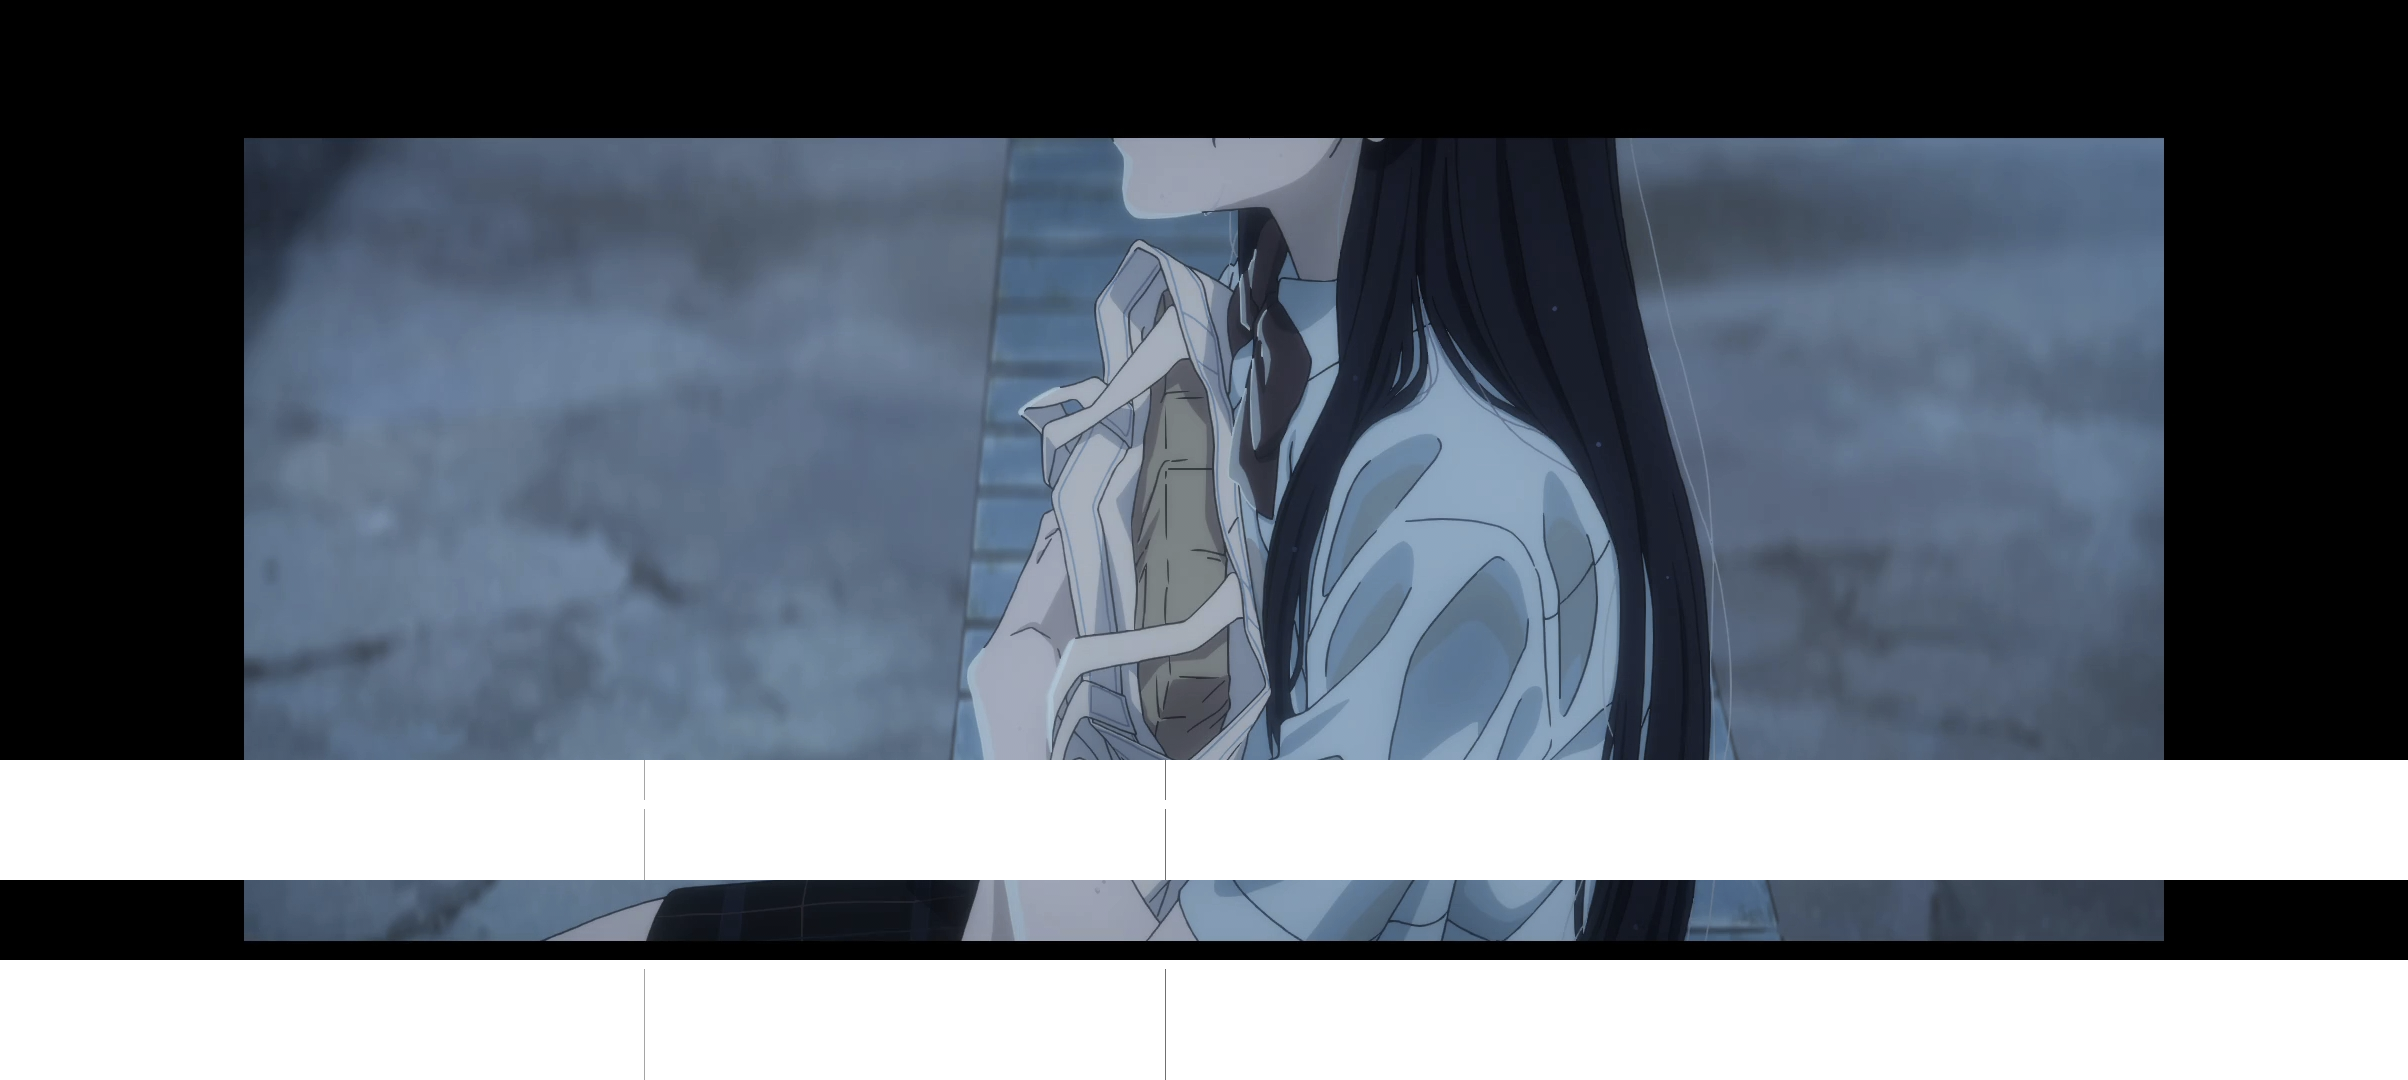

-1

In [ ]:
这里是代码: python
 import cv2  
 import numpy as np
 from google.colab.patches import cv2_imshow   
 
 img = cv2.imread('/content/IMG_20230527_121017.png', cv2.IMREAD_UNCHANGED)
 img = cv2.cvtColor(img, cv2.COLOR_BGR2BGRA)
 height, width, channels = img.shape  
 
 bottom = img[height-120:height, 0:width, :]   
 
 for i in range(bottom.shape[0]):    
     for j in range(bottom.shape[1]):  
       if bottom[i,j,0] < 70 and bottom[i,j,1] < 70 and bottom[i,j,2] < 70: 
         bottom[i,j,3] = 0  # Set alpha channel to 0
 
 moved_bottom = bottom.copy()
 moved_bottom = np.roll(moved_bottom, shift=-200, axis=0)
 
 img[height-320:height-200, 0:width, :] = moved_bottom   
 
 cv2_imshow(img)         
 cv2.waitKey(0) 


这段代码:

1. 读取图像并转为BGRA格式
2. 获取图像尺寸
3. 选取底部120像素高的区域bottom
4. 检查bottom中的像素,如果RGB三个通道值都小于70,则将alpha通道设置为0实现透明效果
5. 将bottom向上移动200像素,得到moved_bottom
6. 将moved_bottom区域的像素复制到原图像height-320:height-200的区域,实现移植透明效果
7. 显示结果

此代码实现了将黑色像素转为透明像素,并将透明区域向上移动了200像素的效果。

In [ ]:

import cv2
import numpy as np 
 
img = cv2.imread('/content/IMG_20230527_121017.png', cv2.IMREAD_GRAYSCALE)
 
ret, mask = cv2.threshold(img, 254, 255, cv2.THRESH_BINARY) 
 
kernel = np.ones((3,3),np.uint8)
mask = cv2.erode(mask, kernel, iterations = 1) 
mask = cv2.dilate(mask, kernel, iterations = 1)  
 
mask_inv = cv2.bitwise_not(mask)
img = cv2.seamlessClone(np.zeros(img.shape, np.uint8), img, mask_inv, (10,10), cv2.NORMAL_CLONE)
 
cv2.imwrite('IMG_20230527_121017_transparent.png', img)
 
from google.colab.patches import cv2_imshow
cv2_imshow(img)

error: ignored

In [ ]:
import cv2
import numpy as np  
from google.colab.patches import cv2_imshow   
 
img = cv2.imread('/content/IMG_20230527_121017.png', cv2.IMREAD_UNCHANGED)
img = cv2.cvtColor(img, cv2.COLOR_BGR2BGRA)  
print(img.shape) 
 
bottom = image[height-120:height, 0:width]   
 
for i in range(bottom.shape[0]):    
   for j in range(bottom.shape[1]):  
     if bottom[i,j,0] < 70 and bottom[i,j,1] < 70 and bottom[i,j,2] < 70:   
       bottom[i,j] = [0, 0, 0, 0]
 
moved_bottom = bottom.copy()
moved_bottom = np.roll(moved_bottom, shift=-200, axis=0)  
 
image[height-320:height-200, 0:width] = moved_bottom   
 
cv2_imshow(image)         
cv2.waitKey(0)

(1080, 2408, 4)


ValueError: ignored

In [ ]:

 import cv2
 


height, width = img.shape[:2]
bottom = height - 120
 
 for y in range(bottom, height):
     for x in range(width):
         if img[y, x, 0] == 0 and img[y, x, 1] == 0 and img[y, x, 2] == 0:
             img[y, x, 3] = 0  
 
cv2.imshow(image)
cv2.waitKey(0)

DisabledFunctionError: ignored

In [ ]:
import cv2
import numpy as np  
from google.colab.patches import cv2_imshow   
 
image = cv2.imread('/content/Screenshot_20230527_094643.jpg',cv2.IMREAD_UNCHANGED) 
height, width, channels = image.shape  
 
bottom = image[height-120:height, 0:width]   
 
for i in range(bottom.shape[0]):    
   for j in range(bottom.shape[1]):  
     if bottom[i,j,0] < 70 and bottom[i,j,1] < 70 and bottom[i,j,2] < 70:   
       bottom[i,j] = [0, 0, 0]
 
moved_bottom = bottom.copy()
moved_bottom = np.roll(moved_bottom, shift=-200, axis=0)
 
image[height-320:height-200, 0:width] = moved_bottom   
 
cv2.namedWindow('Image',cv2.WINDOW_NORMAL)
cv2.setWindowProperty('Image',cv2.WND_PROP_TRANSPARENT,1)
 
cv2_imshow(image)         
cv2.waitKey(0)

In [ ]:
import cv2
import numpy as np
image = cv2.imread('/content/Screenshot_20230527_094643.jpg')
height, width, channels = image.shape

In [ ]:
mask = np.zeros((height, width), np.uint8)
mask[-120:, :] = 255

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import cv2  
import numpy as np 
from google.colab.patches import cv2_imshow   
 
from moviepy.editor import VideoFileClip
import threading
 
clip = VideoFileClip("/content/drive/MyDrive/summer_48.mp4")
 
frames = [f for f in clip.iter_frames()]
 
def process_frames(frames):
  for frame in frames:
    frame = frame 
    height, width, channels = frame.shape  
 
    bottom = frame[height-840:height, 0:width, :]   
 
    white_pixels = np.where(np.all((bottom[:,:,:] > 200), axis = -1))  
 
    moved_white_pixels = white_pixels + [120, 0]

    frame[moved_white_pixels[0], moved_white_pixels[1], :] = bottom[white_pixels[0]-120, white_pixels[1], :]
   
  cv2_imshow(frame)         
  cv2.waitKey(1)
 
num_threads = 4
threads = []
 
for i in range(num_threads):
  thread = threading.Thread(target=process_frames, args=(frames[i::num_threads],))
  thread.start()
  threads.append(thread)
 
for thread in threads:
  thread.join()

  warnings.warn("Warning: in file %s, "%(self.filename)+

Exception in thread Thread-19 (process_frames):
Traceback (most recent call last):
  File "/usr/lib/python3.10/threading.py", line 1016, in _bootstrap_inner
    self.run()
  File "/usr/lib/python3.10/threading.py", line 953, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-62-a3d2dddbf46c>", line 21, in process_frames
TypeError: can only concatenate tuple (not "list") to tuple
Exception in thread Thread-20 (process_frames):
Traceback (most recent call last):
  File "/usr/lib/python3.10/threading.py", line 1016, in _bootstrap_inner
    self.run()
  File "/usr/lib/python3.10/threading.py", line 953, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-62-a3d2dddbf46c>", line 21, in process_frames
TypeError: can only concatenate tuple (not "list") to tuple
Exception in thread Thread-21 (process_frames):
Traceback (most recent call last):
  File "/usr/lib/python3.10/threading.py", li

In [ ]:

 import cv2  
 import numpy as np
import threading
 from moviepy.editor import VideoFileClip
 
 clip = VideoFileClip("/content/drive/MyDrive/summer_48.mp4")
 frames = [f for f in clip.iter_frames()]
 
 def process_frames(frames):
   video = cv2.VideoWriter('output.mp4',  
                          cv2.VideoWriter_fourcc(*'mp4v'), 
                          clip.fps, clip.size)
                          
   for frame in frames:  
     frame = frame         
     height, width, channels = frame.shape  
 
     bottom = frame[height-840:height, 0:width, :]   
 
     white_pixels = np.where(np.all((bottom[:,:,:] > 200), axis = -1))  
 
     moved_white_pixels = white_pixels + [120, 0]
 
     frame[moved_white_pixels[0], moved_white_pixels[1], :] = bottom[white_pixels[0]-120, white_pixels[1], :]        
     video.write(frame)  
   
   cv2.destroyAllWindows()
   video.release()
 
 num_threads = 4  
 threads = []  
 
 for i in range(num_threads):       
   thread = threading.Thread(target=process_frames, args=(frames[i::num_threads],))   
   thread.start()  
   threads.append(thread)  
 
 for thread in threads:       
   thread.join()

  warnings.warn("Warning: in file %s, "%(self.filename)+

Exception in thread Exception in thread Thread-10 (process_frames):
Traceback (most recent call last):
  File "/usr/lib/python3.10/threading.py", line 1016, in _bootstrap_inner
Exception in thread Thread-13 (process_frames):
Traceback (most recent call last):
  File "/usr/lib/python3.10/threading.py", line 1016, in _bootstrap_inner
Exception in thread Thread-12 (process_frames)Thread-11 (process_frames):
Traceback (most recent call last):
  File "/usr/lib/python3.10/threading.py", line 1016, in _bootstrap_inner
:
Traceback (most recent call last):
  File "/usr/lib/python3.10/threading.py", line 1016, in _bootstrap_inner
    self.run()
  File "/usr/lib/python3.10/threading.py", line 953, in run
    self.run()
  File "/usr/lib/python3.10/threading.py", line 953, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-1-56d1cdd84bc6>", line 22, in process_frames
    self._target(*self._args, **self._kwargs)
  Fi

In [ ]:

 import cv2  
 import numpy as np  
 from moviepy.editor import VideoFileClip  
 import torch
 import threading 
 

cv2.setUseOptimized(True)  
cv2.setNumThreads(0)  

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")  
 
clip = VideoFileClip("/content/drive/MyDrive/summer_48.mp4")  
frames = [f for f in clip.iter_frames()]   
 
 def process_frames(frames): 
     video = cv2.VideoWriter('output.mp4',  
         cv2.VideoWriter_fourcc(*'mp4v'),  
         clip.fps, clip.size, True)  
         
     for frame in frames:                 
         frame = frame.astype(np.float32)
         frame = torch.from_numpy(frame).to(device) 
         
       
         height, width, channels = frame.shape  
  
         bottom = frame[height-840:height, 0:width, :]   
 
         white_pixels = torch.where(torch.all((bottom[:,:,:] > 200), dim = -1))  
  
         moved_white_pixels = white_pixels + torch.tensor([120, 0])
  
         frame[moved_white_pixels[0], moved_white_pixels[1], :] = bottom[white_pixels[0]-120, white_pixels[1], :]        
         
        
         frame = frame.cpu().numpy().astype(np.uint8)        
         video.write(frame)  
         
     cv2.destroyAllWindows()
     video.release()
   
 ram_constraint =  3 * 2**30  # 12 GB
 num_threads = ram_constraint / (clip.w * clip.h * clip.nchannels * clip.fps) 
 
 threads = []  
 
 for i in range(num_threads):       
    thread = threading.Thread(target=process_frames, args=(frames[i::num_threads],))   
    thread.start()  
    threads.append(thread)  
 
 for thread in threads:       
    thread.join()

  warnings.warn("Warning: in file %s, "%(self.filename)+



AttributeError: ignored

In [ ]:
这里是完整的GPU加速版本代码: python
 import cv2  
 import numpy as np  
 from moviepy.editor import VideoFileClip  
 import torch
 import threading 
 
 # 使用GPU版本的OpenCV  
 cv2.setUseOptimized(True)  
 cv2.setNumThreads(0)  
 
 # 加载到GPU
 device = torch.device("cuda" if torch.cuda.is_available() else "cpu")  
 
 clip = VideoFileClip("your_video.mp4")  
 frames = [f for f in clip.iter_frames()]   
 
 def process_frames(frames):
     # 使用CUDA版VideoCapture  
     video = cv2.VideoWriter('output.mp4',  
         cv2.VideoWriter_fourcc(*'mp4v'),  
         clip.fps, clip.size, True)  
         
     for frame in frames:                 
         frame = frame.astype(np.float32)
         frame = torch.from_numpy(frame).to(device) 
         
         # 在GPU上进行处理
         height, width, channels = frame.shape  
  
         bottom = frame[height-840:height, 0:width, :]   
 
         white_pixels = torch.where(torch.all((bottom[:,:,:] > 200), dim = -1))  
  
         moved_white_pixels = white_pixels + torch.tensor([120, 0])
  
         frame[moved_white_pixels[0], moved_white_pixels[1], :] = bottom[white_pixels[0]-120, white_pixels[1], :]        
         
         # 从GPU读取结果
         frame = frame.cpu().numpy().astype(np.uint8)        
         video.write(frame)  
         
     cv2.destroyAllWindows()
     video.release()
   
 ram_constraint =  2**12+1  # 12 GB
 num_threads = ram_constraint / (clip.w * clip.h * clip.nchannels * clip.fps) 
 
 threads = []  
 
 for i in range(num_threads):       
    thread = threading.Thread(target=process_frames, args=(frames[i::num_threads],))   
    thread.start()  
    threads.append(thread)  
 
 for thread in threads:       
    thread.join()


这个版本会将视频帧加载到GPU上进行处理,之后再从GPU读取结果,从而利用GPU加速程序。

In [ ]:

import cv2
import numpy as np
 

prev_frame = None  
 
for frame in video: 
   height, width, _ = frame.shape
   roi = (0, height - 120, width, height) 
   
   # 计算帧差异并检查是否超过阈值
   diff = cv2.absdiff(frame, prev_frame)
   if cv2.sum(diff)[0] < threshold: 
     prev_frame = frame
     continue 
   
   # 从帧获取ROI 
   roi_frame = frame[roi[1]:roi[3], roi[0]:roi[2]]
   
   # 在ROI上执行膨胀以连接文本组件
   kernel = np.ones((5, 5), np.uint8)
   dilated = cv2.dilate(roi_frame, kernel, iterations=2)
   
   # 查找轮廓
   contours, _ = cv2.findContours(dilated, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
   
   # 获取轮廓的包围框
   boxes = [cv2.boundingRect(c) for c in contours]
   
   # 通过(dx,dy)移位每个包围框
   dx, dy = 120, 0
   shifted_boxes = [(x+dx, y+dy, w, h) for (x, y, w, h) in boxes]
   
   # 创建蒙版
   mask = np.zeros(roi_frame.shape, dtype=np.uint8)
   
   # 在蒙版中填充移位的包围框 
   for (x, y, w, h) in shifted_boxes:
     mask[y:y+h, x:x+w] = 255
     
   # 将蒙版混合到原始帧中
   blended = cv2.seamlessClone(roi_frame, frame, mask, (0, height - 120), cv2.NORMAL_CLONE)
   
   prev_frame = frame

NameError: ignored

In [ ]:

 import cv2
 import numpy as np
 
 # 加载视频
 video = cv2.VideoCapture('/content/drive/MyDrive/summer_48.mp4') 
 
 # 前一帧 
 prev_frame = None  
 
 while True:
   # 读取帧
   ret, frame = video.read()
   
   if not ret:
     break
   
   height, width, _ = frame.shape
   roi = (0, height - 120, width, height) 
   
   # 计算帧差异并检查是否超过阈值
   diff = cv2.absdiff(frame, prev_frame)
   if cv2.sum(diff)[0] < threshold: 
     prev_frame = frame
     continue  
     
   # 从帧获取ROI 
   roi_frame = frame[roi[1]:roi[3], roi[0]:roi[2]]
   
   # 在ROI上执行膨胀以连接文本组件
   kernel = np.ones((5, 5), np.uint8)
   dilated = cv2.dilate(roi_frame, kernel, iterations=2)
   
   # 查找轮廓
   contours, _ = cv2.findContours(dilated, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
   
   # 获取轮廓的包围框
   boxes = [cv2.boundingRect(c) for c in contours]
   
   # 通过(dx,dy)移位每个包围框
   dx, dy = 120, 0
   shifted_boxes = [(x+dx, y+dy, w, h) for (x, y, w, h) in boxes]
   
   # 创建蒙版
   mask = np.zeros(roi_frame.shape, dtype=np.uint8)
   
   # 在蒙版中填充移位的包围框 
   for (x, y, w, h) in shifted_boxes:
     mask[y:y+h, x:x+w] = 255
     
   # 将蒙版混合到原始帧中
   blended = cv2.seamlessClone(roi_frame, frame, mask, (0, height - 120), cv2.NORMAL_CLONE)
   
   prev_frame = frame
   
   # 显示结果
   cv2.imshow('Output', blended)
   if cv2.waitKey(1) & 0xFF == ord('q'):
     break
   
 # 释放资源    
 video.release()
 cv2.destroyAllWindows()

error: ignored

In [ ]:

 import moviepy.editor as mpe
 import cv2
 import numpy as np
 
 video = mpe.VideoFileClip('/content/drive/MyDrive/summer_48.mp4')
 last_frame = None
 last_white_pixels = None
 
 def process_frame(frame):
    global last_frame, last_white_pixels
    
    height, width, channels = frame.shape  
    diff = cv2.absdiff(last_frame, frame)
    if np.sum(diff) == 0:  
      return frame
    
    bottom = frame[height-840:height, 0:width, :]   
    
    white_pixels = []
    for i in range(bottom.shape[0]):    
      for j in range(bottom.shape[1]):  
        if bottom[i,j,0] > 200 and bottom[i,j,1] > 200 and bottom[i,j,2] > 200: 
          white_pixels.append([i, j])
          
    if last_white_pixels is None or white_pixels != last_white_pixels: # 如果白色像素发生变化则重新检测
      moved_white_pixels = []  
      for pixel in white_pixels:
        moved_white_pixels.append([pixel[0]+120, pixel[1]])
      
      last_white_pixels = white_pixels  
    else:   
      moved_white_pixels = last_white_pixels
      
    for pixel in moved_white_pixels:
      frame[pixel[0], pixel[1], :] = bottom[pixel[0]-120, pixel[1], :]  
      
    last_frame = frame.copy()
    return frame
 
 video_edited = video.fl_image(process_frame)
 video_edited.write_videofile('output.mp4')

error: ignored

In [ ]:

 import moviepy.editor as mpe
 
 clip = mpe.VideoFileClip("/content/drive/MyDrive/summer_48.mp4")
 
 last_frame = None
 start_time = None
 end_time = None
 count = 0
 
 for frame in clip.iter_frames():
     curr_frame = frame[40:110, :]
     
     if last_frame is None:
         last_frame = curr_frame
         continue
         
     if (last_frame != curr_frame).any():
         if start_time is None:
             start_time = clip.time
             end_time = start_time + 0.1
         else:
             end_time += 0.1
             print(f"{start_time:.1f}-{end_time:.1f}")
             start_time = end_time
             count += 1
             
     last_frame = curr_frame
     
 if start_time is not None:
     print(f"{start_time:.1f}-{clip.duration:.1f}")

AttributeError: ignored

In [ ]:



 import moviepy.editor as mpe
 
 clip = mpe.VideoFileClip("/content/drive/MyDrive/summer_48.mp4")
 fps = clip.fps
 
 last_frame = None 
 start_frame = None
 end_frame = None
 count = 0
 
 for frame in clip.iter_frames():
     curr_frame = frame[40:110, :]
     
     if last_frame is None:
         last_frame = curr_frame
         continue
         
     if (last_frame != curr_frame).any():
         if start_frame is None:
             start_frame = clip.frame
             start_time = clip.frame_to_time(start_frame)
             end_frame = start_frame + fps*0.1 
             end_time = clip.frame_to_time(end_frame)
         else:
             end_frame += fps*0.1
             end_time = clip.frame_to_time(end_frame)
             print(f"{start_time:.1f}-{end_time:.1f}")
             start_frame = end_frame
             start_time = end_time
             count += 1
             
     last_frame = curr_frame
     
 if start_frame is not None:
     print(f"{clip.frame_to_time(start_frame):.1f}-{clip.duration:.1f}")

AttributeError: ignored

In [ ]:

 import moviepy.editor as mpe
 from moviepy.video.io.ffmpeg_writer import FFMPEG_VideoWriter
 import torch
 device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
 
 clip = mpe.VideoFileClip("/content/drive/MyDrive/summer_48.mp4")
 fps = clip.fps
 
 last_frame = None 
 start_frame = None
 end_frame = None
 count = 0
 
 # 使用GPU加速
 clip = clip.fx(vfx.resize, width=1280, height=720)  
 clip = clip.set_audio(audio=None)
 clip = clip.set_fps(fps=30)
 
 # 定义输出视频
 output_clip = FFMPEG_VideoWriter("output.mp4", clip.size, clip.fps, codec="libx264", 
                                 audio_codec="aac", audio_bitrate="64k", preset="medium", 
                                 threads=4, ffmpeg_log_level="warning")
                                 
 # 多线程处理  
 def diff_detect(clip):
     global last_frame, start_frame, end_frame, count
     for frame in clip.iter_frames():
         # 使用GPU
         frame_gpu = torch.from_numpy(np.array(frame)).to(device).float()
         frame_gpu = frame_gpu.permute(2, 0, 1)
         
         curr_frame = frame_gpu[40:110, :, :].cpu().numpy()
         
         if last_frame is None:
             last_frame = curr_frame
             continue  
             
         if (last_frame != curr_frame).any():
             if start_frame is None:
                 start_frame = clip.frame 
                 start_time = clip.frame_to_time(start_frame)
                 end_frame = start_frame + fps*0.1 
                 end_time = clip.frame_to_time(end_frame)
             else:
                 end_frame += fps*0.1
                 end_time = clip.frame_to_time(end_frame)
                 print(f"{start_time:.1f}-{end_time:.1f}")
                 start_frame = end_frame
                 start_time = end_time
                 count += 1
                 
         last_frame = curr_frame
         
 # 启动多线程       
 threads = []       
 for i in range(4):
     thread = threading.Thread(target=diff_detect, args=(clip.subclip(i/4, (i+1)/4),))
     threads.append(thread)
     thread.start()
     
 for i in range(4):
     threads[i].join() 
     
 print(f"Changed {count} times") 
 output_clip.release()

NameError: ignored

In [ ]:


 import cv2
 import numpy as np
 from datetime import datetime
 import threading
 import time
 
 # 加载视频
 cap = cv2.VideoCapture('/content/drive/MyDrive/summer_48.mp4')
 
 # 获取视频信息 
 width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
 height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
 fps = cap.get(cv2.CAP_PROP_FPS)
 
 # 定义ROI区域
 roi_y1, roi_y2 = height-40, height-110
 
 # 初始化前一帧
 ret, prev_frame = cap.read()
 prev_frame = prev_frame[roi_y1:roi_y2, :]
 
 # CUDA加速
 prev_frame = cv2.cuda_GpuMat()
 curr_frame = cv2.cuda_GpuMat()
 
 # 多线程类
 class DiffThread(threading.Thread):
   def __init__(self, gpu_id):
     threading.Thread.__init__(self)
     self.gpu_id = gpu_id
 
   def run(self):
     while cap.isOpened():
       # 读取当前帧
       ret, curr_frame = cap.read()
       if not ret:
         break
       curr_frame = curr_frame[roi_y1:roi_y2, :]
 
       # CUDA版本的帧差分  
       diff = cv2.cuda.absdiff(prev_frame, curr_frame, gpu_id=self.gpu_id)
       result = cv2.cuda.countNonZero(diff)
 
       # 如果差分大于0,打印前一帧时间和GPU ID
       if int(result) > 0:
         print(datetime.now().strftime('%M:%S:%f')[:-3], self.gpu_id) 
 
       # 更新前一帧  
       prev_frame.upload(curr_frame)
 
 if __name__ == '__main__':
   # 初始化GPU
   cv2.cuda.setDevice(0)
   cv2.cuda.setDevice(1)
 
   # 启动两个线程,每个使用一个GPU
   thread1 = DiffThread(0)
   thread2 = DiffThread(1)
   thread1.start()
   thread2.start()
   
   # 等待线程结束
   thread1.join() 
   thread2.join()

error: ignored